In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Load the Demographics, ECG, and Labels

In [2]:
ecg_tensor = torch.load('transformer_data/output_file_updated.pt')
ecg_tensor = ecg_tensor.view(6428, 700, 12)
print(ecg_tensor.shape)

torch.Size([6428, 700, 12])


In [3]:
labels_tensor = torch.load('transformer_data/labels_updated.pt')
demo_tensor = torch.load('transformer_data/other_features_file_encoded.pt')
print(labels_tensor.shape)
print(demo_tensor.shape)
new_dtype = torch.float32
demo_tensor = demo_tensor.to(dtype=new_dtype)
demo_tensor.shape

torch.Size([6428])
torch.Size([6428, 70])


torch.Size([6428, 70])

## Transformer Model

In [4]:
batch_size = 512
learning_rate = 0.001
ecg_train_data, ecg_test_data, demo_train_data, demo_test_data, train_labels, test_labels = train_test_split(ecg_tensor, demo_tensor, labels_tensor,test_size=0.1, random_state=42)
train_dataset = TensorDataset(ecg_train_data, demo_train_data, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last= True)
test_dataset = TensorDataset(ecg_test_data, demo_test_data, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last= True)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=700):  # Change max_len to 8388
        super(PositionalEncoding, self).__init__()
        self.encoding = self._generate_positional_encoding(d_model, max_len)
        
    def _generate_positional_encoding(self, d_model, max_len):
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros((max_len, d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        return pe

    def forward(self, x):
        result = x + self.encoding[:, :x.size(1)].detach()
        return result

class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, ff_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead)
        self.dropout_attn = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, d_model)
        )
        self.dropout_ffn = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        attn_output, _ = self.self_attn(x, x, x)
        x = x + self.dropout_attn(attn_output)
        x = self.norm1(x)
        ffn_output = self.ffn(x)
        x = x + self.dropout_ffn(ffn_output)
        x = self.norm2(x)
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, input_size, dem_size, d_model, nhead, ff_dim, num_transformer_blocks, mlp_units, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.embedding_dem = nn.Linear(dem_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(d_model, nhead, ff_dim, dropout) for _ in range(num_transformer_blocks)]
        )
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, mlp_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_units, 3)
        )

    def forward(self, x, x_dem):
        print(x.shape)
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x_dem = self.embedding_dem(x_dem)
        x_dem = x_dem.unsqueeze(1)
        x = torch.cat([x, x_dem], dim=1)
        for block in self.transformer_blocks:
            x = block(x)
        x = self.global_avg_pooling(x.permute(0, 2, 1)).squeeze(2)
        x = self.mlp(x)
        return F.softmax(x, dim=1)

input_size = 12
dem_size = 70
sequence_length = 700
model = TransformerClassifier(input_size=input_size, dem_size = dem_size, d_model=256, nhead=1, ff_dim=512, num_transformer_blocks=1, mlp_units=64, dropout=0.25)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
print(model)

TransformerClassifier(
  (embedding): Linear(in_features=12, out_features=256, bias=True)
  (embedding_dem): Linear(in_features=70, out_features=256, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_blocks): ModuleList(
    (0): TransformerBlock(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (dropout_attn): Dropout(p=0.25, inplace=False)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.25, inplace=False)
        (3): Linear(in_features=512, out_features=256, bias=True)
      )
      (dropout_ffn): Dropout(p=0.25, inplace=False)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (global_avg_pooling): AdaptiveAvgPool1d(output_size=1)
  (mlp): Sequential(
    (0): Linear(in_featur

In [6]:
num_classes = 3
class_counts = torch.zeros(num_classes)
for _, _, targets in train_dataloader:
    class_counts += torch.bincount(targets, minlength=num_classes)

total_samples = class_counts.sum()
class_weights = total_samples / (num_classes * class_counts)

class_weights /= class_weights.sum()

In [7]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc, accuracy_score
from torch.nn import CrossEntropyLoss
criterion = CrossEntropyLoss(weight=class_weights)
all_outputs = []
all_targets = []
all_logits = []
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for inputs, demo_inputs, targets in train_dataloader: 
        optimizer.zero_grad()
        outputs = model(inputs, demo_inputs)
        predictions = outputs.argmax(dim=1)
        all_logits.extend(predictions.numpy())
        all_outputs.extend(outputs[:, 1].detach().numpy())
        all_targets.extend(targets.cpu().numpy())
        class_weights_batch = class_weights[targets]
        unweighted_loss = criterion(outputs, targets)
        weighted_loss = (unweighted_loss * class_weights_batch).mean()
        weighted_loss.backward()
        optimizer.step()
        running_loss += weighted_loss.item()
        
    average_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {average_loss:.4f}")\
    
    accuracy = accuracy_score(all_targets, all_logits)

    print(f" Accuracy: {accuracy:.4f}")

torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
Epoch [1/5] - Train Loss: 0.3465
 Accuracy: 0.3182
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
Epoch [2/5] - Train Loss: 0.3463
 Accuracy: 0.3286
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
torch.Size([512, 700, 12])
Epoch [

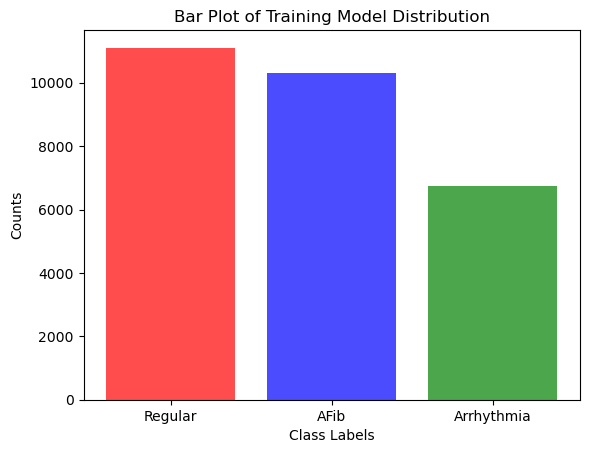

In [8]:
import numpy as np
import matplotlib.pyplot as plt

class_labels = ['Regular', 'AFib', 'Arrhythmia']

unique_values, counts = np.unique(all_logits, return_counts=True)

plt.bar(class_labels, counts, color=['red', 'blue', 'green'], alpha=0.7)
plt.xlabel('Class Labels')
plt.ylabel('Counts')
plt.title('Bar Plot of Training Model Distribution')

# Adding legend
#plt.legend()

plt.show()


In [9]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc, accuracy_score
model.eval()  
all_outputs = []
all_targets = []
all_logits = []
with torch.no_grad():
    for inputs, dem_inputs, targets in test_dataloader:
        outputs = model(inputs, dem_inputs)
        predictions = outputs.argmax(dim=1)
        all_logits.extend(predictions.cpu().numpy())
        all_outputs.extend(outputs[:, 1].cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
    
accuracy = accuracy_score(all_targets, all_logits)

print(f"Accuracy: {accuracy:.4f}")


torch.Size([512, 700, 12])
Accuracy: 0.3340


In [10]:
unique_values, counts = np.unique(all_logits, return_counts=True)
unique_values, counts

(array([0, 1, 2]), array([480,  18,  14]))

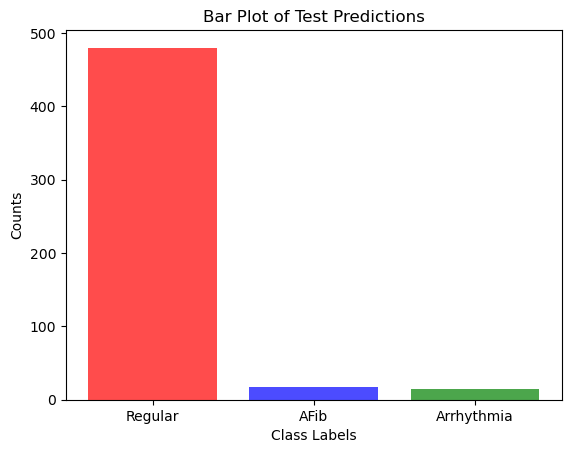

In [12]:
import numpy as np
import matplotlib.pyplot as plt

class_labels = ['Regular', 'AFib', 'Arrhythmia']

unique_values, counts = np.unique(all_logits, return_counts=True)

plt.bar(class_labels, counts, color=['red', 'blue', 'green'], alpha=0.7)
plt.xlabel('Class Labels')
plt.ylabel('Counts')
plt.title('Bar Plot of Test Predictions')

# Adding legend
#plt.legend()

plt.show()

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(all_targets, all_logits, average = None)
recall = recall_score(all_targets, all_logits, average = None)
f1 = f1_score(all_targets, all_logits, average = None)

In [20]:
print('F1_score is: ' + str(f1))
print('Precison is: ' + str(precision))
print('Recall is: ' + str(recall))

F1_score is: [0.50381679 0.04316547 0.02608696]
Precison is: [0.34375    0.16666667 0.21428571]
Recall is: [0.94285714 0.02479339 0.01388889]


In [13]:
torch.save(model.state_dict(), '../saved_model/transformer_model.pth')